In [88]:
# Veriyi okumak ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt


# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılan kütüphaneler
import warnings
warnings.filterwarnings('ignore')

# Tensorflow Warning Engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [89]:
df = pd.read_csv('/content/ASELSAN.csv' ,decimal=',')
df.head()


,Tarih,Şimdi,Açılış,Yüksek,Düşük,Hac.,Fark %
0,27.03.2024,55.70,54.00,56.45,52.20,"70,10M","5,09%"
1,26.03.2024,53.00,55.60,55.95,52.85,"45,06M","-3,99%"
2,25.03.2024,55.20,56.35,58.00,55.00,"57,63M","-2,04%"
3,22.03.2024,56.35,57.95,58.45,56.20,"64,62M","-2,68%"
4,21.03.2024,57.90,56.40,58.55,56.40,"98,02M","3,49%"


In [90]:
def check_df(dataframe, size=5):
    print('\n\n--- Shape -----------------------------------------------------------------------')
    print(dataframe.shape)
    print('\n\n--- Types -----------------------------------------------------------------------')
    print(dataframe.dtypes)
    print('\n\n--- Head ------------------------------------------------------------------------')
    print(dataframe.head(size))
    print('\n\n--- Tail ------------------------------------------------------------------------')
    print(dataframe.tail(size))
    print('\n\n--- NA --------------------------------------------------------------------------')
    print(dataframe.isnull().sum())
    print('\n\n--- Quantiles -------------------------------------------------------------------')
    print(df.drop('Tarih', axis=1).quantile([0, 0.05, 0.5, 0.95, 0.99, 1]).T)

In [91]:
check_df(df)



--- Shape -----------------------------------------------------------------------
(310, 7)


--- Types -----------------------------------------------------------------------
Tarih      object
Şimdi     float64
Açılış    float64
Yüksek    float64
Düşük     float64
Hac.       object
Fark %     object
dtype: object


--- Head ------------------------------------------------------------------------
        Tarih  Şimdi  Açılış  Yüksek  Düşük    Hac.  Fark %
0  27.03.2024  55.70   54.00   56.45  52.20  70,10M   5,09%
1  26.03.2024  53.00   55.60   55.95  52.85  45,06M  -3,99%
2  25.03.2024  55.20   56.35   58.00  55.00  57,63M  -2,04%
3  22.03.2024  56.35   57.95   58.45  56.20  64,62M  -2,68%
4  21.03.2024  57.90   56.40   58.55  56.40  98,02M   3,49%


--- Tail ------------------------------------------------------------------------
          Tarih  Şimdi  Açılış  Yüksek  Düşük     Hac.  Fark %
305  06.01.2023  31.45   29.48   32.08  28.25  297,53M   6,79%
306  05.01.2023  29.45   32.8

In [92]:
# Object olan date değişken tipini datetime yapıyoruz
df['Tarih'] = pd.to_datetime(df['Tarih'], format='%d.%m.%Y')

In [93]:
# Sadece Şimdi değişkenine göre bir eğitim yapacağız, bunun için tarih ve Şimdi değişkeninden yeni bir df oluşturuyoruz
tesla_df = df[['Tarih', 'Şimdi']]
tesla_df.head()

,Tarih,Şimdi
0,2024-03-27,55.70
1,2024-03-26,53.00
2,2024-03-25,55.20
3,2024-03-22,56.35
4,2024-03-21,57.90


In [94]:
print('Min Tarih: ', tesla_df['Tarih'].min())
print('Max Tarih: ', tesla_df['Tarih'].max())

Min Tarih:  2023-01-02 00:00:00
Max Tarih:  2024-03-27 00:00:00


In [95]:
# Date değişkenini index yapacağız ve df içindeki kolonunu sileceğiz
tesla_df.index = tesla_df['Tarih']
tesla_df.drop('Tarih', axis=1, inplace=True)
tesla_df.head()

,Şimdi
Tarih,
2024-03-27,55.70
2024-03-26,53.00
2024-03-25,55.20
2024-03-22,56.35
2024-03-21,57.90


In [96]:
# İlerideki bölümlerde ihtiyaç olacağından dolayı result_df adı altında bir df'te saklıyoruz
result_df = tesla_df.copy()
print(tesla_df)

            Şimdi
Tarih            
2024-03-27  55.70
2024-03-26  53.00
2024-03-25  55.20
2024-03-22  56.35
2024-03-21  57.90
...           ...
2023-01-06  31.45
2023-01-05  29.45
2023-01-04  32.58
2023-01-03  34.55
2023-01-02  32.30

[310 rows x 1 columns]


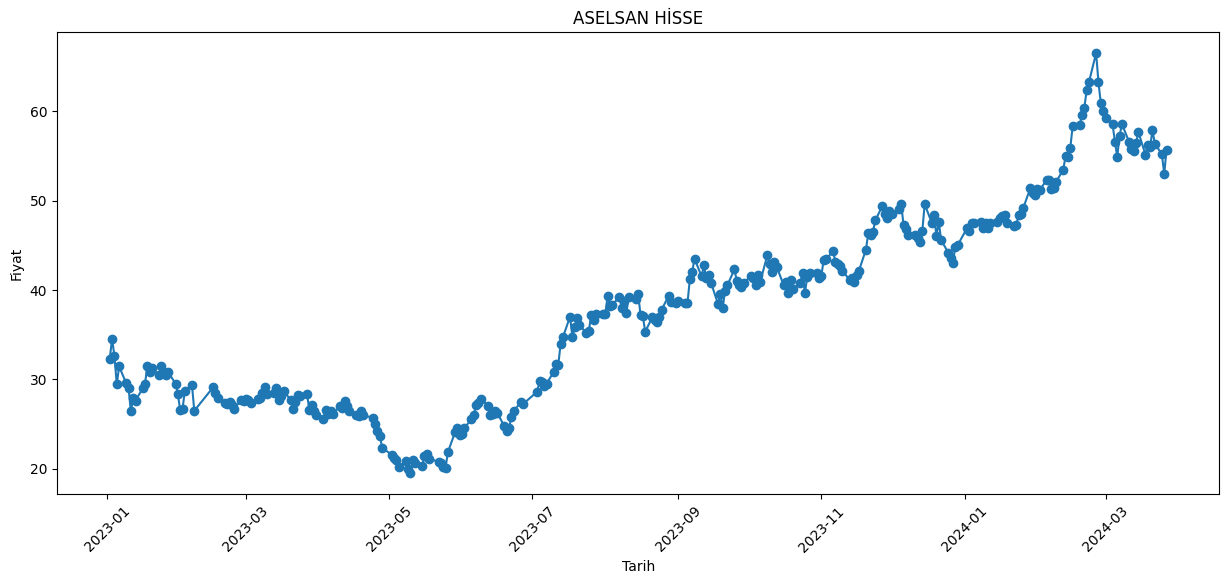

In [97]:
# Şu ana kadar olan kısmı görselleştireceğiz
# plt.figure(figsize=(12,6))
# plt.plot(data['Tarih'],data['Şimdi'], color='blue')
# plt.ylabel('Borsa Kapanış Fiyatı')
# plt.title('Aselsan Hisse')
# plt.xlabel('Zaman')
# plt.show()

plt.figure(figsize=(15,6))
plt.plot(tesla_df['Şimdi'], marker='o')
plt.title('ASELSAN HİSSE')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.xticks(rotation=45)
plt.show()

In [98]:
# Modele sokmadan önce verileri numpy arrayine çevirmemiz gerekiyor
tesla_df = tesla_df.values
tesla_df[0:5]

array([[55.7 ],
       [53.  ],
       [55.2 ],
       [56.35],
       [57.9 ]])

In [99]:
# Sinir ağlarında genel olarak kullanılan veri tipi olan float32'e dönüştürme yapıyoruz
tesla_df = tesla_df.astype('float32')

In [100]:
# Verimizin son hali
type(tesla_df), tesla_df.dtype

(numpy.ndarray, dtype('float32'))

In [101]:
# train-test ayrımının yapılması
# Zaman serilerinde sklearn içinde test train split fonksiyonunu kullanamayız. Çünkü bu fonksiyon
# verileri random olarak seçiyor ve buda zaman bağlamını ve mantık aktarımını bozuyor.
# Bu sebepten dolayı bunu kendi yazdığımız basit bir fonksiyon ile yapacağız.

def split_data(dataframe, test_size):
    pos = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

In [102]:
train, test, pos = split_data(tesla_df, 0.20)
print(train.shape, test.shape)

(248, 1) (62, 1)


In [103]:
# Standartlaştırma işlemlerini yapıyoruz

scaler_train = MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train)

scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

print(train[0:5], test[0:5])

[[0.7701639]
 [0.7127049]
 [0.7595234]
 [0.7839966]
 [0.8169824]] [[0.11960125]
 [0.        ]
 [0.05094123]
 [0.10631204]
 [0.1771872 ]]


In [104]:
# Geçmiş veriler ile feature yaratma

def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X), np.array(Y)

In [105]:
lookback = 20 #20 günlül veri alarak

In [106]:
# Train
x_train, y_train = create_features(train, lookback)

# Test
x_test, y_test = create_features(test, lookback)

In [107]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(228, 20) (228,) (42, 20) (42,)


In [108]:
x_train[0:5]

array([[0.7701639 , 0.7127049 , 0.7595234 , 0.7839966 , 0.8169824 ,
        0.7754842 , 0.7808045 , 0.7584593 , 0.8116622 , 0.78506076,
        0.76803577, 0.772292  , 0.7893169 , 0.8308151 , 0.8031497 ,
        0.753139  , 0.7893169 , 0.8308151 , 0.8446479 , 0.86167276],
       [0.7127049 , 0.7595234 , 0.7839966 , 0.8169824 , 0.7754842 ,
        0.7808045 , 0.7584593 , 0.8116622 , 0.78506076, 0.76803577,
        0.772292  , 0.7893169 , 0.8308151 , 0.8031497 , 0.753139  ,
        0.7893169 , 0.8308151 , 0.8446479 , 0.86167276, 0.88082576],
       [0.7595234 , 0.7839966 , 0.8169824 , 0.7754842 , 0.7808045 ,
        0.7584593 , 0.8116622 , 0.78506076, 0.76803577, 0.772292  ,
        0.7893169 , 0.8308151 , 0.8031497 , 0.753139  , 0.7893169 ,
        0.8308151 , 0.8446479 , 0.86167276, 0.88082576, 0.93083644],
       [0.7839966 , 0.8169824 , 0.7754842 , 0.7808045 , 0.7584593 ,
        0.8116622 , 0.78506076, 0.76803577, 0.772292  , 0.7893169 ,
        0.8308151 , 0.8031497 , 0.753139  , 0

In [109]:
y_train[0:5]

array([0.88082576, 0.93083644, 1.0000001 , 0.9319005 , 0.9127475 ],
      dtype=float32)

In [110]:
# Veri setlerini 3 boyutlu yapıya getirme
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(228, 1, 20) (228, 1) (42, 1, 20) (42, 1)


In [111]:
# Model kurulumu
model = Sequential()
model.add(LSTM(units=50,
               activation='relu',
               input_shape=(x_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [112]:
# Model özeti
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
# Optimizasyon ve değerlendirme metriklerinin ayarlanması
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [114]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min',
                             save_best_only=True, save_weights_only=False, verbose=1)]

In [115]:
# Model fit
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=100,
                    batch_size=40,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
1/6 [====>.........................] - ETA: 11s - loss: 0.4829
Epoch 1: val_loss improved from inf to 0.13555, saving model to mymodel.h5
6/6 [==============================] - 3s 77ms/step - loss: 0.1867 - val_loss: 0.1355
Epoch 2/100
1/6 [====>.........................] - ETA: 0s - loss: 0.3034
Epoch 2: val_loss improved from 0.13555 to 0.10247, saving model to mymodel.h5
6/6 [==============================] - 0s 16ms/step - loss: 0.1197 - val_loss: 0.1025
Epoch 3/100
1/6 [====>.........................] - ETA: 0s - loss: 0.1934
Epoch 3: val_loss improved from 0.10247 to 0.07517, saving model to mymodel.h5
6/6 [==============================] - 0s 12ms/step - loss: 0.0743 - val_loss: 0.0752
Epoch 4/100
1/6 [====>.........................] - ETA: 0s - loss: 0.0813
Epoch 4: val_loss improved from 0.07517 to 0.05475, saving model to mymodel.h5
6/6 [==============================] - 0s 14ms/step - loss: 0.0353 - val_loss: 0.0548
Epoch 5/100
1/6 [====>.........................

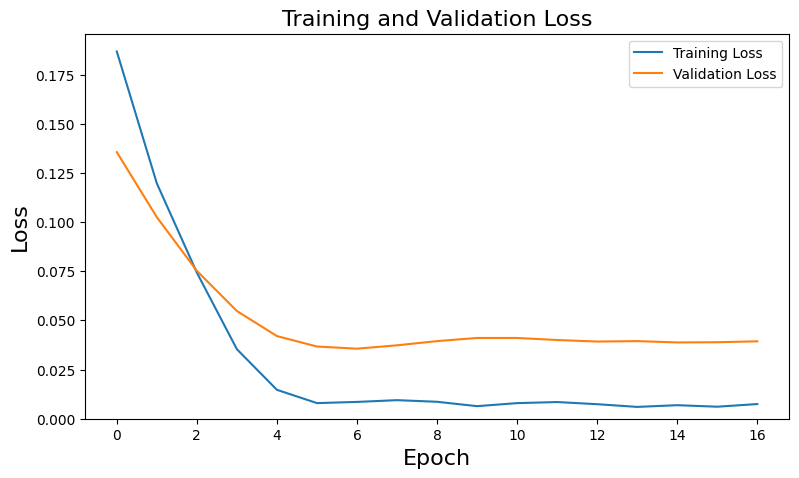

In [116]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

In [117]:
loss = model.evaluate(x_test, y_test, batch_size=40)
print('\nTest Loss: %.1f%%' % (100.0 * loss))

2/2 [==============================] - 0s 7ms/step - loss: 0.0394

Test Loss: 3.9%


In [118]:
# Modelimizden tahminleri alıyoruz
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

2/2 [==============================] - 0s 5ms/step


In [119]:
# Standartlaştırılmış tahmin verilerini gerçek değerlere geri dönüştürüyoruz
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [120]:
# Yukarıdaki aynı işlemi eğitilen ve test edilen veri setlerine de yapıyoruz
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [121]:
# Train RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [122]:
# Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [123]:
print(f'Train RMSE: {train_rmse}')
print(f' Test RMSE: {test_rmse}')

Train RMSE: 2.647602081298828
 Test RMSE: 1.7912875413894653


In [124]:
# Gerçek değerler ile tahmin edilen değerleri train veri seti için kıyaslama
train_prediction_df = result_df[lookback:pos]
train_prediction_df['Predicted'] = train_predict
train_prediction_df.head()

,Şimdi,Predicted
Tarih,,
2024-02-28,60.90,55.396172
2024-02-27,63.25,55.556709
2024-02-26,66.50,56.257614
2024-02-23,63.30,57.188076
2024-02-22,62.40,57.705112


In [125]:
# Gerçek değerler ile tahmin edilen değerleri test veri seti için kıyaslama
test_prediction_df = result_df[pos+lookback:] # pos+lookback yani trainden sonraki kısmı aldık
test_prediction_df['Predicted'] = test_predict
test_prediction_df.head()

,Şimdi,Predicted
Tarih,,
2023-03-07,27.95,27.636484
2023-03-06,27.85,27.680883
2023-03-03,27.30,27.728180
2023-03-02,27.68,27.755539
2023-03-01,27.75,27.949148


In [129]:
# Veri setinin en güncel tarihteki test tahminleri
test_prediction_df.tail(10)

,Şimdi,Predicted
Tarih,,
2023-01-13,27.62,29.405725
2023-01-12,27.95,29.146402
2023-01-11,26.40,29.202869
2023-01-10,29.07,28.695303
2023-01-09,29.55,28.847700
2023-01-06,31.45,28.908510
2023-01-05,29.45,29.345627
2023-01-04,32.58,29.164227
2023-01-03,34.55,29.717947


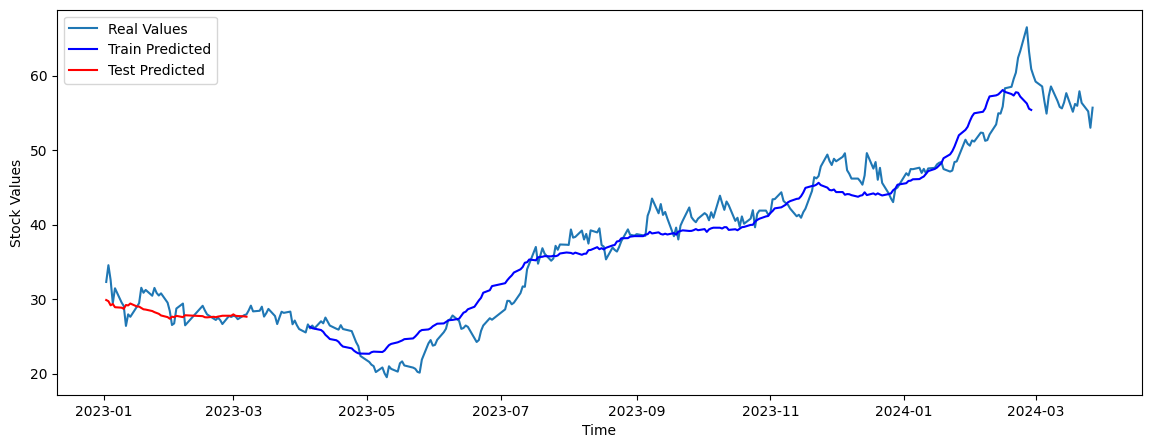

In [127]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme
plt.figure(figsize=(14, 5))
plt.plot(result_df, label='Real Values')
plt.plot(train_prediction_df['Predicted'], color='blue', label='Train Predicted')
plt.plot(test_prediction_df['Predicted'], color='red', label='Test Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()